<a href="https://colab.research.google.com/github/farazabir/nyc-taxi-fare-prediction/blob/main/nyc_taxi_fare_tabularmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('taxifare.csv')

In [4]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
df['fare_amount'].describe()


,fare_amount
count,120000.000000
mean,10.040326
std,7.500134
min,2.500000
25%,5.700000
50%,7.700000
75%,11.300000
max,49.900000


In [6]:
def haversine_distance(df,lat1,long1,lat2,long2):
  r = 6371

  phi1 = np.radians(df[lat1])
  phi2 = np.radians(df[lat2])

  delta_phi = np.radians(df[lat2]-df[lat1])
  delta_lambda = np.radians(df[long2]-df[long1])

  a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
  d = (r*c)

  return d

In [7]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

In [8]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km'],
      dtype='object')

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [12]:
df['pickup_datetime']

,pickup_datetime
0,2010-04-19 08:17:56+00:00
1,2010-04-17 15:43:53+00:00
2,2010-04-17 11:23:26+00:00
3,2010-04-11 21:25:03+00:00
4,2010-04-17 02:19:01+00:00
...,...
119995,2010-04-18 14:33:03+00:00
119996,2010-04-23 10:27:48+00:00
119997,2010-04-18 18:50:40+00:00
119998,2010-04-13 08:14:44+00:00


In [13]:
my_time = df['pickup_datetime'][0]

In [14]:
df['EDTdate'] = df['pickup_datetime']-pd.Timedelta(hours=4)

In [15]:
df['Hour'] = df['EDTdate'].dt.hour

In [16]:
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')

In [17]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [18]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [19]:
cat_cols = ['Hour','AMorPM','Weekday']
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [20]:
y_col = ['fare_amount']

In [21]:
df.dtypes

,0
pickup_datetime,"datetime64[ns, UTC]"
fare_amount,float64
fare_class,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64
dist_km,float64
EDTdate,"datetime64[ns, UTC]"


In [22]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [23]:
df['Hour'].head()

,Hour
0,4
1,11
2,7
3,17
4,22


In [24]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [25]:
cats = np.stack([hr,ampm,wkdy],axis=1)

In [26]:
cats = torch.tensor(cats,dtype=torch.int64)

In [27]:
consts = np.stack([df[col].values for col in cont_cols],axis=1)
consts = torch.tensor(consts,dtype=torch.float)

In [28]:
y = torch.tensor(df[y_col].values,dtype=torch.float).reshape(-1,1)

In [29]:
y.shape

torch.Size([120000, 1])

In [30]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [31]:
cat_szs

[24, 2, 7]

In [32]:
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]

In [33]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])

In [34]:
embeddingz = []
for i,e in enumerate(selfembeds):
  embeddingz.append(e(cats[:,i]))

In [35]:
embeddingz

[tensor([[ 0.8251,  0.7887,  0.1377,  ...,  0.1119, -0.2090, -1.0941],
         [-0.0776,  1.6766, -0.7642,  ..., -2.1973, -0.1663, -0.7687],
         [ 0.2608,  1.0464, -0.5914,  ..., -0.7038,  0.7907, -0.8548],
         ...,
         [ 1.5253,  0.0884, -0.1452,  ..., -0.5079,  1.4190, -0.0904],
         [ 0.8251,  0.7887,  0.1377,  ...,  0.1119, -0.2090, -1.0941],
         [ 0.0058,  1.4903,  0.7300,  ...,  0.0789,  0.7736, -1.1484]],
        grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.8985],
         [ 0.8985],
         [ 0.8985],
         ...,
         [-0.4636],
         [ 0.8985],
         [-0.4636]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.3868,  1.0328, -0.4845,  0.7336],
         [ 1.6258,  1.0350, -0.9694,  0.7543],
         [ 1.6258,  1.0350, -0.9694,  0.7543],
         ...,
         [-1.7335,  0.8236, -0.5888,  2.9379],
         [ 1.1549, -1.0071, -0.8872,  0.0414],
         [ 1.6258,  1.0350, -0.9694,  0.7543]], grad_fn=<EmbeddingBackward0>)]

In [36]:
z = torch.cat(embeddingz,1)

In [37]:
selfembdrop = nn.Dropout(0.4)

In [38]:
conts = torch.tensor(consts,dtype=torch.float)

<ipython-input-38-bed6b0317221>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conts = torch.tensor(consts,dtype=torch.float)


In [39]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_embs = sum((nf for ni, nf in emb_szs))
        n_in = n_embs + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat, x_cont):
        embeddings = []

        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))

        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)

        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


In [41]:
torch.manual_seed(33)
model = TabularModel(emb_szs,conts.shape[1],1,[200,100],p=0.4)

In [42]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [43]:
batch_size = 60000
test_size = int(batch_size*0.2)

In [44]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
cont_train = conts[:batch_size-test_size]
cont_test = conts[batch_size-test_size:batch_size]

In [45]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [46]:
len(cat_train)

48000

In [47]:
len(cont_train)

48000

In [49]:
import time

start_time = time.time()

epochs = 300

losses = []

for i in range(epochs):
  i+=1
  y_pred = model(cat_train,cont_train)
  loss = torch.sqrt(criterion(y_pred,y_train))
  losses.append(loss.item())

  if i%10 == 1:
    print(f'epch: {i} loss is {loss}')


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


duration = time.time() - start_time
print(f'Traning took {duration/60} minutes')

epch: 1 loss is 11.693744659423828
epch: 11 loss is 11.115148544311523
epch: 21 loss is 10.730971336364746
epch: 31 loss is 10.456559181213379
epch: 41 loss is 10.231260299682617
epch: 51 loss is 10.032174110412598
epch: 61 loss is 9.840131759643555
epch: 71 loss is 9.640734672546387
epch: 81 loss is 9.417686462402344
epch: 91 loss is 9.177379608154297
epch: 101 loss is 8.892127990722656
epch: 111 loss is 8.574835777282715
epch: 121 loss is 8.217015266418457
epch: 131 loss is 7.812793731689453
epch: 141 loss is 7.382485389709473
epch: 151 loss is 6.919118404388428
epch: 161 loss is 6.4465107917785645
epch: 171 loss is 5.972180366516113
epch: 181 loss is 5.482560634613037
epch: 191 loss is 5.018428325653076
epch: 201 loss is 4.649052143096924
epch: 211 loss is 4.3092522621154785
epch: 221 loss is 4.073262691497803
epch: 231 loss is 3.9581615924835205
epch: 241 loss is 3.8727946281433105
epch: 251 loss is 3.816596269607544
epch: 261 loss is 3.796797037124634
epch: 271 loss is 3.748227357

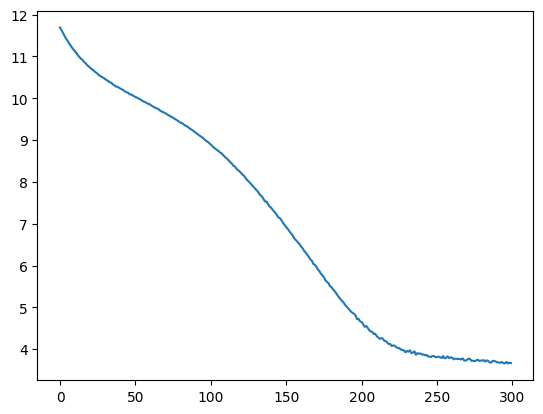

In [50]:
plt.plot(range(epochs),losses)


In [54]:
with torch.no_grad():
  y_val = model(cat_test,cont_test)
  loss = torch.sqrt(criterion(y_eval,y_test))

In [55]:
loss

tensor(3.6393)

In [58]:
for i in range(10):
  diff = np.abs(y_val[i].item() - y_test[i].item())
  print(f'{i} Predicted {y_val[i].item():8.2f} True: {y_test[i].item():8.2f} Difference: {diff:8.2f}')

0 Predicted     3.78 True:     2.90 Difference:     0.88
1 Predicted    23.73 True:     5.70 Difference:    18.03
2 Predicted    10.11 True:     7.70 Difference:     2.41
3 Predicted    14.47 True:    12.50 Difference:     1.97
4 Predicted     6.40 True:     4.10 Difference:     2.30
5 Predicted     5.57 True:     5.30 Difference:     0.27
6 Predicted     3.01 True:     3.70 Difference:     0.69
7 Predicted    15.36 True:    14.50 Difference:     0.86
8 Predicted     2.38 True:     5.70 Difference:     3.32
9 Predicted    11.53 True:    10.10 Difference:     1.43


In [59]:
torch.save(model.state_dict(),'Taximodel.pt')